In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import sys
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
from sklearn.model_selection import KFold # For Cross Validation
from pathlib import Path
import fastai # importing fastai library
from fastai.vision import *
from fastai import *
print("The version of Fastai is:",fastai.__version__)

The version of Fastai is: 1.0.61


In [12]:
data_path = Path("C:/Users/teckone/Desktop/COVID-19-master/X-Ray_Image_DataSet")
# Please choose the path of image accordingly
# For binary put only COVID-19 images and No-Finding images only in the image database

In [13]:
# This block of code is for 5- fold cross validation
n_folds = 5   
kf=KFold(n_splits=n_folds, shuffle= True)
data_files = list(data_path.glob('**/*.*'))
splits=list(kf.split(list(range(len(data_files)))))
len(data_files)

625

In [14]:
# The 5 fold cross validation starts from fold = 0 to fold =4, we can put it manually or put in for loop. Here its done manually
fold=0   
val_idx=splits[fold][1]
val_idx,len(val_idx)

(array([  5,  11,  19,  26, ..., 619, 621, 622, 623]), 125)

In [15]:
data=(ImageList.from_folder(data_path)
      .split_by_idx(val_idx)
      .label_from_folder()
      .transform(get_transforms(),size=256)
      .databunch()
      .normalize()
     )

In [16]:
print(data.classes, len(data.train_ds), len(data.valid_ds))

['Covid-19', 'No_findings'] 500 125


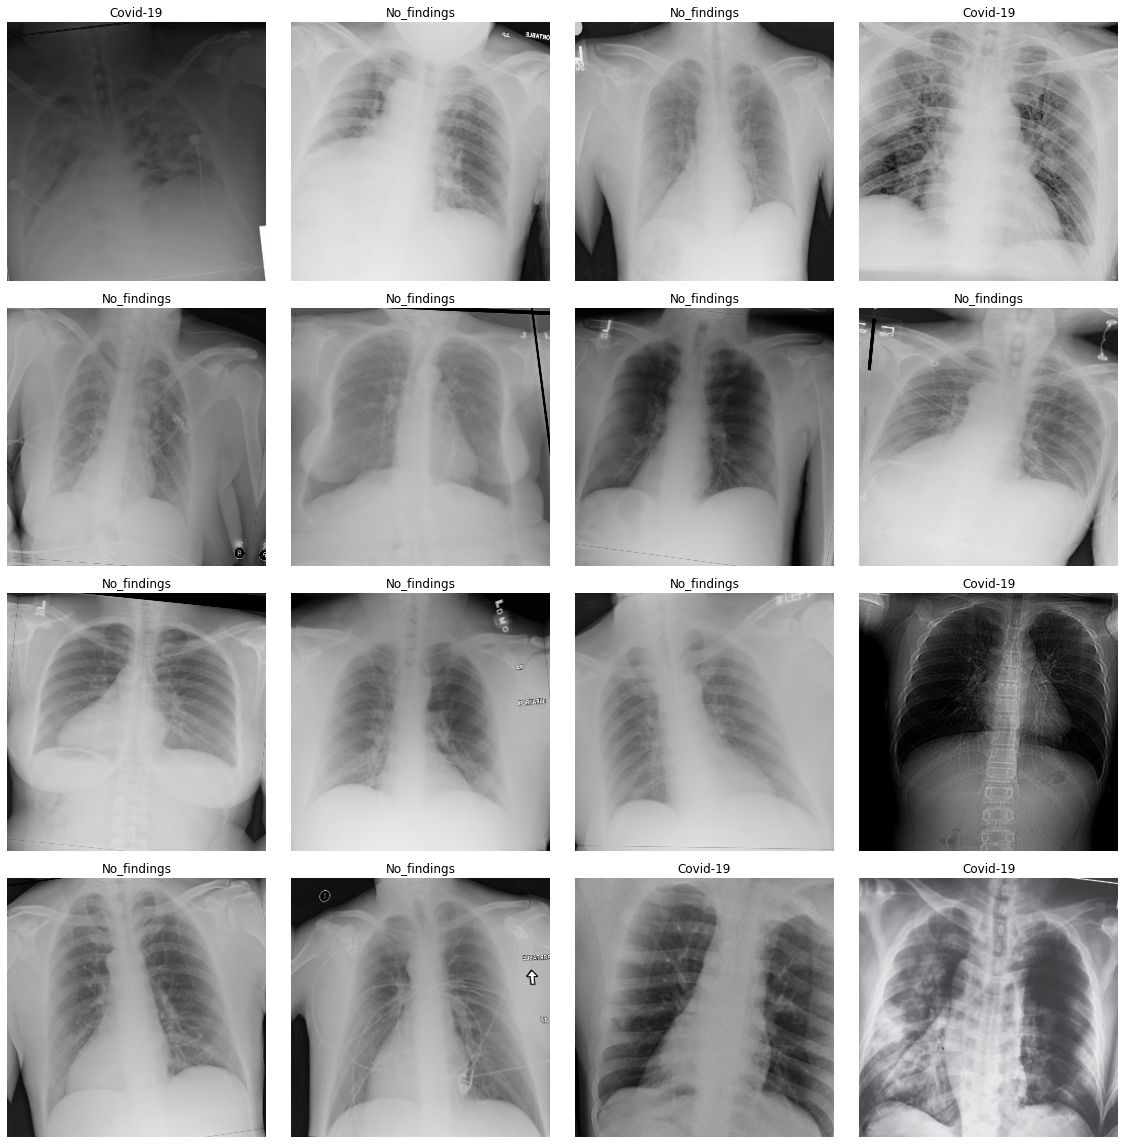

In [17]:
data.show_batch(rows=4)

In [34]:
# Darknet block (DN block)
def conv_block(in_channels, out_channels, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )    

In [40]:
# 3 X Convolution Block
def triple_conv(in_channels, out_channels):
    return nn.Sequential(
        conv_block(in_channels, out_channels),
        conv_block(out_channels, in_channels, size=1),  
        conv_block(in_channels, out_channels)
    )

In [41]:
# Maxpooling Layer
def maxpooling():
    return nn.MaxPool2d(kernel_size=2, stride=2)

In [42]:
# overall DarkCovid-Net Model
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
   
)

In [43]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [44]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [45]:
# train the model, epoch choosen here is 100 and learning rate 3e-3
learn.fit_one_cycle(100, max_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.449237,0.881665,0.232000,02:15
1,0.383156,1.253880,0.232000,01:38


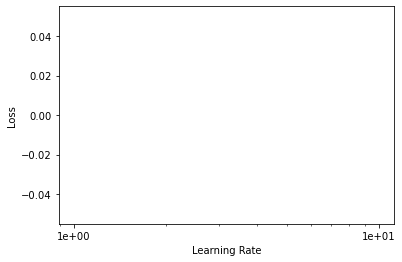

In [46]:
learn.recorder.plot()


In [47]:
learn.export(data_path / f'fold{fold}.pk1') # save the trained data
learn.save(data_path / f'fold{fold}') # save the trained data

In [251]:
#learn = learn.load("C:/Users/user/Desktop/COVID-19-master/Binary/fold2")  , load the trained data

In [48]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 125


In [50]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [51]:
# Calculate the accuracy of the model
accuracy(probs,targets) 

tensor(0.2320)

In [52]:
# Calculate other metrices
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

125 29 0.232
[[29  0]
 [96  0]]
              precision    recall  f1-score   support

    Covid-19       0.23      1.00      0.38        29
 No_findings       0.00      0.00      0.00        96

    accuracy                           0.23       125
   macro avg       0.12      0.50      0.19       125
weighted avg       0.05      0.23      0.09       125



C:\Users\teckone\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
interp = ClassificationInterpretation.from_learner(learn)

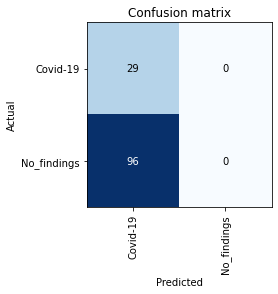

In [55]:
# Draw confusion matrix
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);